In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prifair as pf
import torch

from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch import nn, optim

In [67]:
epsilon = 1.0
delta = 1e-5
epochs = 10
relative_weight_bound = 1.5
lr = 5e-3

In [68]:
df = pd.read_csv("../datasets/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


/var/folders/lm/m2_fflbn48511bslzzhkjymw0000gn/T/ipykernel_47832/3653637024.py:4: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


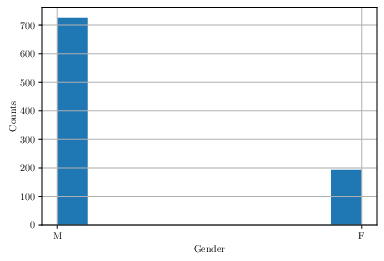

In [130]:
df["Sex"].hist()
plt.xlabel("Gender")
plt.ylabel("Counts")
plt.show()
plt.savefig("../figures/heart_imbalance.pgf")

In [70]:
bp_idx = df[df["RestingBP"] == 0].index[0]
bp_avg = df["RestingBP"].mean()
df.loc[bp_idx, "RestingBP"] = bp_avg

df.drop("Cholesterol", axis=1, inplace=True)

cat_cols = [1, 2, 5, 7, 9]
num_cols = [0, 3, 6, 8]

ct = ColumnTransformer([
    ('categoric', OneHotEncoder(), cat_cols),
    ('numeric', StandardScaler(), num_cols)
    ], remainder='passthrough')

data_clean = ct.fit_transform(df.values)
print('Cleaned Data:')
print(data_clean[0])

Cleaned Data:
[0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0
 -1.4331398004436657 0.4148614371130468 1.3829282169443904
 -0.832432393131704 0 0]


In [71]:
X, y = data_clean.T[:-1].T.astype('float32'), data_clean.T[-1].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(len(X_train))
print(len(X_test))

734
184


In [72]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 24),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(24, 2),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.model(x)


train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train.astype(int))), batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test.astype(int))), batch_size=16, shuffle=False)

### Train Vanilla

In [101]:
model_vanilla, metrics_vanilla = pf.training.train_vanilla(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    epochs=epochs,
    lr=lr,
)

100%|██████████| 46/46 [00:00<00:00, 757.58it/s]


Epoch: 1 Train Loss: 0.60 Train Acc@1: 69.90 Val Loss: 0.35 Val Acc@1: 85.42 


100%|██████████| 46/46 [00:00<00:00, 1221.16it/s]


Epoch: 2 Train Loss: 0.43 Train Acc@1: 82.94 Val Loss: 0.32 Val Acc@1: 90.62 


100%|██████████| 46/46 [00:00<00:00, 1157.31it/s]


Epoch: 3 Train Loss: 0.39 Train Acc@1: 84.08 Val Loss: 0.28 Val Acc@1: 91.15 


100%|██████████| 46/46 [00:00<00:00, 1220.42it/s]


Epoch: 4 Train Loss: 0.39 Train Acc@1: 84.65 Val Loss: 0.28 Val Acc@1: 90.62 


100%|██████████| 46/46 [00:00<00:00, 1086.60it/s]


Epoch: 5 Train Loss: 0.41 Train Acc@1: 84.63 Val Loss: 0.30 Val Acc@1: 90.62 


100%|██████████| 46/46 [00:00<00:00, 1252.11it/s]


Epoch: 6 Train Loss: 0.39 Train Acc@1: 85.64 Val Loss: 0.29 Val Acc@1: 88.54 


100%|██████████| 46/46 [00:00<00:00, 1209.76it/s]


Epoch: 7 Train Loss: 0.37 Train Acc@1: 85.95 Val Loss: 0.32 Val Acc@1: 89.58 


100%|██████████| 46/46 [00:00<00:00, 1357.29it/s]


Epoch: 8 Train Loss: 0.36 Train Acc@1: 85.29 Val Loss: 0.29 Val Acc@1: 91.15 


100%|██████████| 46/46 [00:00<00:00, 1310.80it/s]


Epoch: 9 Train Loss: 0.35 Train Acc@1: 85.31 Val Loss: 0.28 Val Acc@1: 90.10 


100%|██████████| 46/46 [00:00<00:00, 1125.96it/s]

Epoch: 10 Train Loss: 0.35 Train Acc@1: 86.94 Val Loss: 0.28 Val Acc@1: 90.62 


### Train DP-SGD

In [81]:
model_dpsgd, metrics_dpsgd = pf.training.train_dpsgd(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=1.2,
    epochs=epochs,
    lr=lr,
)

/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/opacus/privacy_engine.py:114: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("U

Epoch: 1 Train Loss: 0.69 Train Acc@1: 52.64 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.33, δ = 1e-05) 


46it [00:00, 543.85it/s]             


Epoch: 2 Train Loss: 0.68 Train Acc@1: 57.47 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.44, δ = 1e-05) 


46it [00:00, 564.80it/s]             


Epoch: 3 Train Loss: 0.68 Train Acc@1: 58.25 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.54, δ = 1e-05) 


46it [00:00, 373.42it/s]             


Epoch: 4 Train Loss: 0.68 Train Acc@1: 55.71 Val Loss: 0.67 Val Acc@1: 54.69 (ε = 0.62, δ = 1e-05) 


46it [00:00, 450.52it/s]             


Epoch: 5 Train Loss: 0.67 Train Acc@1: 58.36 Val Loss: 0.66 Val Acc@1: 58.85 (ε = 0.70, δ = 1e-05) 


46it [00:00, 523.61it/s]             


Epoch: 6 Train Loss: 0.65 Train Acc@1: 63.74 Val Loss: 0.63 Val Acc@1: 65.10 (ε = 0.76, δ = 1e-05) 


46it [00:00, 526.88it/s]             


Epoch: 7 Train Loss: 0.65 Train Acc@1: 63.76 Val Loss: 0.61 Val Acc@1: 68.75 (ε = 0.83, δ = 1e-05) 


46it [00:00, 534.60it/s]             


Epoch: 8 Train Loss: 0.60 Train Acc@1: 68.20 Val Loss: 0.56 Val Acc@1: 72.92 (ε = 0.89, δ = 1e-05) 


46it [00:00, 537.74it/s]             


Epoch: 9 Train Loss: 0.59 Train Acc@1: 69.79 Val Loss: 0.52 Val Acc@1: 77.60 (ε = 0.94, δ = 1e-05) 


46it [00:00, 522.36it/s]             


Epoch: 10 Train Loss: 0.60 Train Acc@1: 71.47 Val Loss: 0.45 Val Acc@1: 80.21 (ε = 0.99, δ = 1e-05) 


### Train DP-SGD-F

In [103]:
model_dpsgdf, metrics_dpsgdf = pf.training.train_dpsgdf(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=epsilon,
    target_delta=delta,
    base_clipping_threshold=1.2,
    epochs=epochs,
    group_labels=torch.LongTensor(X_train[:, 0]),
    lr=lr
)

/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Training Model...


  0%|          | 0/46 [00:00<?, ?it/s]/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 46/46 [00:00<00:00, 75.00it/s]


Epoch: 1 Train Loss: 0.70 Train Acc@1: 49.99 Val Loss: 0.69 Val Acc@1: 56.25 (ε = 0.33, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 208.58it/s]


Epoch: 2 Train Loss: 0.69 Train Acc@1: 55.02 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.44, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 405.55it/s]


Epoch: 3 Train Loss: 0.68 Train Acc@1: 55.34 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.54, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 355.04it/s]


Epoch: 4 Train Loss: 0.68 Train Acc@1: 56.24 Val Loss: 0.67 Val Acc@1: 54.69 (ε = 0.62, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 427.76it/s]


Epoch: 5 Train Loss: 0.67 Train Acc@1: 56.33 Val Loss: 0.66 Val Acc@1: 54.69 (ε = 0.70, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 446.09it/s]


Epoch: 6 Train Loss: 0.64 Train Acc@1: 60.43 Val Loss: 0.63 Val Acc@1: 54.69 (ε = 0.76, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 416.79it/s]


Epoch: 7 Train Loss: 0.64 Train Acc@1: 61.84 Val Loss: 0.60 Val Acc@1: 55.73 (ε = 0.83, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 395.83it/s]


Epoch: 8 Train Loss: 0.65 Train Acc@1: 60.65 Val Loss: 0.56 Val Acc@1: 67.19 (ε = 0.89, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 416.92it/s]


Epoch: 9 Train Loss: 0.62 Train Acc@1: 62.87 Val Loss: 0.49 Val Acc@1: 79.17 (ε = 0.94, δ = 1e-05) 


100%|██████████| 46/46 [00:00<00:00, 427.66it/s]

Epoch: 10 Train Loss: 0.57 Train Acc@1: 70.03 Val Loss: 0.46 Val Acc@1: 79.17 (ε = 0.99, δ = 1e-05) 


### Train DP-SGD-W

In [99]:
model_dpsgd_w, metrics_dpsgd_w = pf.training.train_dpsgd_weighted(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=1.2,
    epochs=epochs,
    weighting="sensitive_attr",
    relative_weight_bound=relative_weight_bound,
    labels=X_train[:, 0],
    lr=lr
)

Reweighing...
Training Model...


46it [00:00, 572.22it/s]             


Epoch: 1 Train Loss: 0.69 Train Acc@1: 48.71 Val Loss: 0.70 Val Acc@1: 47.92 (ε = 0.20, δ = 1e-05) 


46it [00:00, 553.96it/s]             


Epoch: 2 Train Loss: 0.70 Train Acc@1: 48.26 Val Loss: 0.69 Val Acc@1: 54.69 (ε = 0.28, δ = 1e-05) 


46it [00:00, 511.68it/s]             


Epoch: 3 Train Loss: 0.68 Train Acc@1: 54.14 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.34, δ = 1e-05) 


46it [00:00, 558.88it/s]             


Epoch: 4 Train Loss: 0.70 Train Acc@1: 49.90 Val Loss: 0.68 Val Acc@1: 54.69 (ε = 0.40, δ = 1e-05) 


46it [00:00, 508.56it/s]             


Epoch: 5 Train Loss: 0.69 Train Acc@1: 52.09 Val Loss: 0.66 Val Acc@1: 66.67 (ε = 0.45, δ = 1e-05) 


46it [00:00, 477.30it/s]             


Epoch: 6 Train Loss: 0.67 Train Acc@1: 57.34 Val Loss: 0.64 Val Acc@1: 73.44 (ε = 0.49, δ = 1e-05) 


46it [00:00, 545.02it/s]             


Epoch: 7 Train Loss: 0.66 Train Acc@1: 60.86 Val Loss: 0.62 Val Acc@1: 63.54 (ε = 0.53, δ = 1e-05) 


46it [00:00, 565.74it/s]             


Epoch: 8 Train Loss: 0.63 Train Acc@1: 64.77 Val Loss: 0.59 Val Acc@1: 78.65 (ε = 0.57, δ = 1e-05) 


46it [00:00, 569.60it/s]             


Epoch: 9 Train Loss: 0.63 Train Acc@1: 62.05 Val Loss: 0.55 Val Acc@1: 78.65 (ε = 0.61, δ = 1e-05) 


46it [00:00, 571.02it/s]             


Epoch: 10 Train Loss: 0.60 Train Acc@1: 67.46 Val Loss: 0.49 Val Acc@1: 79.69 (ε = 0.64, δ = 1e-05) 


## Fairness Analysis

In [77]:
import matplotlib as mpl

mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

Test Accuracy: 90.217391
Test Accuracy: 79.347826
Test Accuracy: 78.260870
Test Accuracy: 78.804348


/var/folders/lm/m2_fflbn48511bslzzhkjymw0000gn/T/ipykernel_47832/2543330026.py:35: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


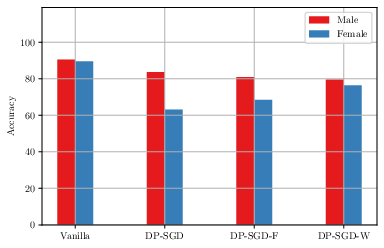

In [111]:
preds_vanilla = pf.utils.evaluate_model(model_vanilla, test_loader)
preds_dpsgd = pf.utils.evaluate_model(model_dpsgd, test_loader)
preds_dpsgdf = pf.utils.evaluate_model(model_dpsgdf, test_loader)
preds_dpsgdw = pf.utils.evaluate_model(model_dpsgd_w, test_loader)
sex_col = X_test[:, 0]

model_names = ["Vanilla", "DP-SGD", "DP-SGD-F", "DP-SGD-W"]
preds = [preds_vanilla, preds_dpsgd, preds_dpsgdf, preds_dpsgdw]
accuracies = {c: np.zeros(len(model_names)) for c in np.unique(sex_col)}
tprs = {c: np.zeros(len(model_names)) for c in np.unique(sex_col)}
fprs = {c: np.zeros(len(model_names)) for c in np.unique(sex_col)}

for i, model in enumerate(zip(model_names, preds)):
    correct_mask = preds[i] == y_test
    for c in accuracies.keys():
        class_mask = sex_col == c
        accuracies[c][i] = np.sum(correct_mask & class_mask) / np.sum(class_mask)

        tn, fp, fn, tp = confusion_matrix(y_test[class_mask], preds[i][class_mask]).ravel()
        tprs[c][i] = tp / (tp + fn)
        fprs[c][i] = fp / (fp + tn)


width = 0.2
ind = np.arange(len(model_names))
cmap = plt.get_cmap("Set1")(range(5))
for i, c in enumerate(accuracies.keys()):
    plt.bar(ind + width * i, accuracies[c] * 100, width, label=str(c), color=cmap[i])

plt.ylabel("Accuracy")
plt.legend(["Male", "Female"])
plt.xticks(ind + width * (len(accuracies.keys()) - 1) / 2, model_names)
plt.ylim(0, 119)
plt.grid()
plt.show()
plt.savefig("../figures/cardio_utility.pgf")

/var/folders/lm/m2_fflbn48511bslzzhkjymw0000gn/T/ipykernel_47832/2422474227.py:18: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


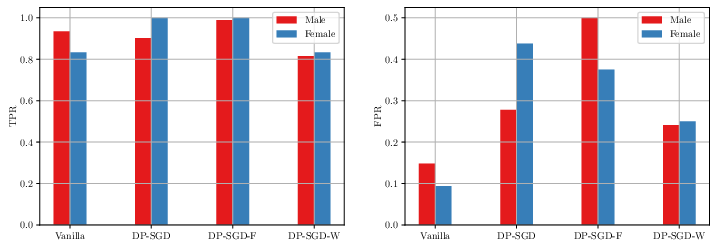

In [124]:
ax1, ax2 = plt.subplots(1, 2, figsize=(12, 4))[1]

width = 0.2
ind = np.arange(len(model_names))
cmap = plt.get_cmap("Set1")(range(5))
for i, c in enumerate(tprs.keys()):
    ax1.bar(ind + width * i, tprs[c], width, label=str(c), color=cmap[i])
    ax2.bar(ind + width * i, fprs[c], width, label=str(c), color=cmap[i])

ax1.set_ylabel("TPR")
ax1.legend(["Male", "Female"])
ax1.set_xticks(ind + width * (len(tprs.keys()) - 1) / 2, model_names)
ax1.grid()
ax2.set_ylabel("FPR")
ax2.legend(["Male", "Female"])
ax2.set_xticks(ind + width * (len(fprs.keys()) - 1) / 2, model_names)
ax2.grid()
plt.show()
plt.savefig("../figures/cardio_equal_opp.pgf")